In [1]:
using LinearAlgebra
using SparseArrays
using PyCall
using Plots
using IterTools
using Distributions
using ProgressMeter

In [2]:
py"""
def allActions(nAct, nPlayers):
    import itertools
    idX = list(itertools.product(list(range(1, nAct + 1)), repeat=nPlayers)) * nPlayers
    return idX
"""
allActions(nAct, nPlayers) = py"allActions"(nAct, nPlayers)

allActions (generic function with 1 method)

In [3]:
function generateCorrespondences(nActions, nPlayers)
    nElements = nActions^nPlayers
    Actions = allActions(nActions, nPlayers)
    allCombos = [[findall(x -> x==tuple(circshift([j for j in Actions[i]], -1*(p))...), Actions)[p+1] for p=0:nPlayers-1] for i=1:nElements]
    
    return Actions, allCombos
end

generateCorrespondences (generic function with 1 method)

In [4]:
function generateGames(Gamma, nSim, allCombos, nActions, nPlayers)
    """
    Create Covariance Matrix from Gamma
    
    Return Random Payoff Matrices: nPlayers*nElements x nSim
    
    """
    nElements = nActions^nPlayers
    cov = Matrix(1.0I, nPlayers * nElements, nPlayers * nElements)
    
    """ Cycle through each of the combinations and assign them the appropriate Gamma """
    for c in allCombos
        cov[c[1], c[2:end]] .= Gamma/(nPlayers-1)
        cov[c[2:end], c[1]] .= Gamma/(nPlayers-1)
    end
        
    """ draw from a Gaussian using this covariance matrix """

    return rand(MvNormal(zeros(nPlayers * nElements), cov), nSim)

end

generateGames (generic function with 1 method)

In [5]:
function getActionProbs(qValues, agentParams)
    """
    qValues: nPlayer x nActions x nSim
    return: nPlayer x nActions x nSim
    """
    alpha, tau, gamma = agentParams
    
    return exp.(tau * qValues)./sum(exp.(tau * qValues), dims=2)
end

getActionProbs (generic function with 1 method)

In [6]:
function chooseActions(actionProbs, gameParams)
    """
    arg: actionProbs: nPlayer x nActions x nSim
    return: nPlayer x nSim
    """
    
    nSim, nPlayers, nActions = gameParams

    return [[rand(Bernoulli(actionProbs[p, 1, s])) + 1 for p=1:nPlayers] for s=1:nSim]
end

chooseActions (generic function with 1 method)

In [7]:
function findPayoffs(choices, gameParams, corr, actions, payoffs)
    nSim, nPlayers, nActions = gameParams
    
    choiceIdx = [corr[findall(x -> x==tuple(choices[s]...), actions)[1]] for s=1:nSim]
    return [payoffs[choiceIdx[s], s] for s=1:nSim]
end

findPayoffs (generic function with 1 method)

In [8]:
function qUpdate!(qValues, payoffs, gameParams, agentParams, correlations, actions)

    nSim, nPlayers, nActions = gameParams
    alpha, tau, gamma = agentParams
    
    actionProbs = getActionProbs(qValues, agentParams)
    bChoice = chooseActions(actionProbs, gameParams)
    rewards = findPayoffs(bChoice, gameParams, correlations, actions, payoffs)

    update = [rewards[s] - diag(qValues[:, bChoice[s], s]) + gamma * findmax(qValues[:, :, s], dims=2)[1] for s=1:nSim]
    
    for s = 1:nSim
        for p = 1:nPlayers
            qValues[p, bChoice[s][p], s] += alpha * update[s][p]
        end
    end
end

qUpdate! (generic function with 1 method)

In [9]:
function checkminMix(actionTracker, nSim, tol)
    T = hcat([reshape(actionTracker[i], nPlayers * nSim * nActions) for i=1:length(actionTracker)]...)
    relDiff = (findmax(T, dims=2)[1] - findmin(T, dims=2)[1])./findmin(T, dims=2)[1]

    part = [relDiff[i*(nActions*nPlayers)+1:(i+1)*(nActions*nPlayers)] for i=0:nSim-1]
    bRemove = [length(findall(x->x<0.01, p))>=length(p) for p in part]
    
    return bRemove
end

checkminMix (generic function with 1 method)

In [32]:
alpha = 0.01
tau = 0.05
gamma = 0.1

initnSim = 20
nPlayers = 3
nActions = 10

Gamma = -0.5

# gameParams = (nSim, nPlayers, nActions)
# agentParams = (alpha, tau, gamma)

t0 = 5000
actions, corr = generateCorrespondences(nActions, nPlayers)

nIter = trunc(Int, 5e4)

allconv = []

Any[]

In [ ]:
@showprogress for a in LinRange(1e-2, 5e-2, 20)
    global alpha = a
    for Gamma in LinRange(-1, 0, 20)
        global nSim = initnSim
    
        qValues = rand(nPlayers, nActions, nSim)
        payoffs = generateGames(Gamma, nSim, corr, nActions, nPlayers)
        actionTracker = []

        converged = 0

        for cIter = 1:nIter

            if cIter==t0
                actionTracker = []
            end    

            if cIter%t0==0 && cIter!=0 && cIter!=t0
                bRemove = checkminMix(actionTracker, nSim, 1e-2)
                removeIdx = findall(bRemove)
                qValues = qValues[:, :, setdiff(1:end, removeIdx)]
                payoffs = payoffs[:, setdiff(1:end, removeIdx)]
                nSim -= length(removeIdx)
                converged += length(removeIdx)

                actionTracker = [] 
            end

            if nSim <= 0
                break
            end

            gameParams = (nSim, nPlayers, nActions)
            agentParams = (alpha, tau, gamma)

            qUpdate!(qValues, payoffs, gameParams, agentParams, corr, actions)
            append!(actionTracker, [getActionProbs(qValues, agentParams)])

        end
        append!(allconv, [alpha, Gamma, converged/initnSim])
    end
end

In [25]:
a = reshape(allconv[3:3:end], 10, 10)[end:-1:1, :]

10×10 Array{Any,2}:
 0.15  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.25  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.2   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.1   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.2   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.15  0.05  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.2   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.3   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.2   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.4   0.0   0.05  0.0  0.0  0.0  0.0  0.0  0.0  0.0

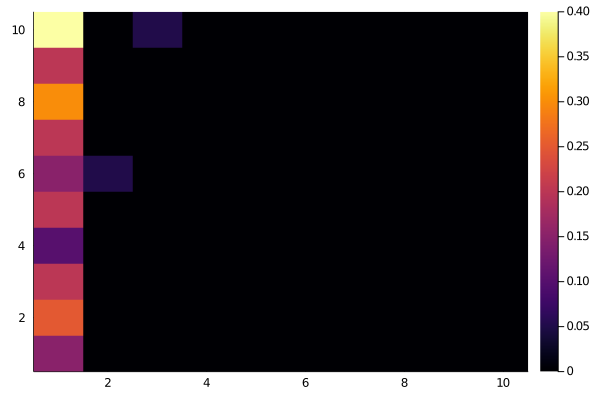

In [26]:
heatmap(a)

In [ ]:
qValues = rand(nPlayers, nActions, nSim)
payoffs = generateGames(Gamma, nSim, corr, nActions, nPlayers)

probs = getActionProbs(qValues, (0.05, 1, 1))
bChoice = [[rand(Bernoulli(probs[p, 1, s])) + 1 for p=1:nPlayers] for s=1:nSim]

choiceIdx = [corr[findall(x -> x==tuple(bChoice[s]...), actions)[1]] for s=1:nSim]

rewards = [payoffs[choiceIdx[s], s] for s=1:nSim]

update = [rewards[s] - diag(qValues[:, bChoice[s], s]) + gamma * findmax(qValues[:, :, s], dims=2)[1] for s=1:nSim]
# [i for i in bChoice[1]]
for s = 1:nSim
    for p = 1:nPlayers
        qValues[p, bChoice[s][p], s] += alpha * update[s][p]
    end
end

In [28]:
tau = 0.05
alpha = 0.02
gamma = 0.1

initnSim = 20
nActions = 2

t0 = 25000

nIter = trunc(Int, 5e4)

allVars = []

Any[]

In [29]:
function getVariance(actionTracker)
    

    T = hcat([reshape(actionTracker[i], nPlayers * nSim * nActions) for i=1:length(actionTracker)]...)
    var = ((1 /length(actionTracker)) * sum(T.^2, dims=2)) - ((1/length(actionTracker)) * sum(T, dims=2)).^2
    part = [var[i*(nActions*nPlayers)+1:(i+1)*(nActions*nPlayers)] for i=0:nSim-1]

    return mean([mean(p) for p in part])

    
end

getVariance (generic function with 1 method)

In [31]:
@showprogress for p = 3:12
    global nPlayers = p
    actions, corr = generateCorrespondences(nActions, nPlayers)
    
    varGamma = []
        @show nPlayers
    for Gamma in LinRange(-1, 0, 10)
        
        global nSim = initnSim

        qValues = rand(nPlayers, nActions, nSim)
        payoffs = generateGames(Gamma, nSim, corr, nActions, nPlayers)

        actionTracker = []

        for cIter = 1:nIter
                
            gameParams = (nSim, nPlayers, nActions)
            agentParams = (alpha, tau, gamma)

            qUpdate!(qValues, payoffs, gameParams, agentParams, corr, actions)
            
            if cIter > t0
                append!(actionTracker, [getActionProbs(qValues, agentParams)])
            end

        end
        append!(varGamma, getVariance(actionTracker))
    end
    
    append!(allVars, [mean(varGamma), std(varGamma)])
end

Progress:  30%|████████████▎                            |  ETA: 0:30:34

nPlayers = 3
nPlayers = 4
nPlayers = 5
nPlayers = 6


LoadError: InterruptException:

In [ ]:
T = hcat([reshape(actionTracker[i], nPlayers * nSim * nActions) for i=1:length(actionTracker)]...)
h = (1/nActions) * sum(((1 / (nIter - t0)) * sum(T, dims=2).^2) - ((1/(nIter - t0)) * sum(T, dims=2)).^2, dims=1)
var = ((1 /length(actionTracker)) * sum(T.^2, dims=2)) - ((1/length(actionTracker)) * sum(T, dims=2)).^2
part = [var[i*(nActions*nPlayers)+1:(i+1)*(nActions*nPlayers)] for i=0:nSim-1]

mean([mean(p) for p in part])
# mean(std(T, dims=2).^2)

In [ ]:
nPlayers